# Practical 2: Exploring Transfer Learning with Pre-trained Models

In [1]:
# Core
import os
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
print("Downloading Cats vs Dogs dataset...")

_URL = "https://download.mlcc.google.com/mledu-datasets/cats_and_dogs_filtered.zip"

zip_path = tf.keras.utils.get_file(
    "cats_and_dogs_filtered.zip",
    origin=_URL,
    extract=True
)

# Base dataset directory
base_dir = os.path.join(os.path.dirname(zip_path), "cats_and_dogs_filtered")

# Handle nested folder case safely
if os.path.exists(os.path.join(base_dir, "train")):
    dataset_dir = base_dir
else:
    dataset_dir = os.path.join(base_dir, "cats_and_dogs_filtered")

train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")

# Class folders
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")
val_cats_dir = os.path.join(validation_dir, "cats")
val_dogs_dir = os.path.join(validation_dir, "dogs")

# Sanity check
print("Train cats path exists:", os.path.exists(train_cats_dir))
print("Train dogs path exists:", os.path.exists(train_dogs_dir))

# Count images
train_cats = len(os.listdir(train_cats_dir))
train_dogs = len(os.listdir(train_dogs_dir))
val_cats = len(os.listdir(val_cats_dir))
val_dogs = len(os.listdir(val_dogs_dir))

print("Dataset loaded successfully!")
print(f"Training Cats: {train_cats}")
print(f"Training Dogs: {train_dogs}")
print(f"Validation Cats: {val_cats}")
print(f"Validation Dogs: {val_dogs}")


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train cats path exists: True
Train dogs path exists: True
Dataset loaded successfully!
Training Cats: 1000
Training Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


In [5]:
# Step 2: Create data generators with augmentation (Optimized for VGG16)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,                     # ✅ correct variable
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,                # ✅ correct variable
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False                  # important for evaluation
)

print("Class labels:", train_generator.class_indices)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class labels: {'cats': 0, 'dogs': 1}


In [6]:
# Load VGG16 base model
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze convolutional base
base_model.trainable = False

# Custom classification head
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,297 (56.64 MB)

 Trainable params: 132,097 (516.00 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        name="Adam_TL"
    ),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)


In [8]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath="best_vgg16_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]


In [10]:
print("Phase 1: Training top layers only (Frozen VGG16)")

history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Phase 1: Training top layers only (Frozen VGG16)
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9462 - auc: 0.9882 - loss: 0.1389
Epoch 1: val_accuracy improved from 0.97077 to 0.97500, saving model to best_vgg16_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 620ms/step - accuracy: 0.9463 - auc: 0.9882 - loss: 0.1389 - val_accuracy: 0.9750 - val_auc: 0.9981 - val_loss: 0.0605
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9258 - auc: 0.9840 - loss: 0.1601
Epoch 2: val_accuracy did not improve from 0.97500
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 536ms/step - accuracy: 0.9259 - auc: 0.9840 - loss: 0.1599 - val_accuracy: 0.9750 - val_auc: 0.9983 - val_loss: 0.0575
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9486 - auc: 0.9893 - loss: 0.1296
Epoch 3: val_accuracy did not improve from 0.97500
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 532ms/step - accuracy: 0.9485 - auc: 0.9893 - loss: 0.1297 - val_accuracy: 0.9750 - val_auc: 0.9984 - val_loss: 0.0576
Epoc

In [11]:
# Get best validation accuracy (not just last epoch)
best_val_acc = max(history_phase1.history.get("val_accuracy", []))
best_train_acc = max(history_phase1.history.get("accuracy", []))

print(f"Phase 1 - Best Training Accuracy: {best_train_acc*100:.2f}%")
print(f"Phase 1 - Best Validation Accuracy: {best_val_acc*100:.2f}%")


Phase 1 - Best Training Accuracy: 96.50%
Phase 1 - Best Validation Accuracy: 98.40%


In [12]:
print("Unfreezing top VGG16 layers for fine-tuning...")

# Unfreeze only top convolutional block (block5)
base_model.trainable = True
for layer in base_model.layers:
    if "block5" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Ensure BatchNorm layers stay frozen
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)

print("Phase 2: Fine-tuning top VGG16 layers")

history_phase2 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Unfreezing top VGG16 layers for fine-tuning...
Phase 2: Fine-tuning top VGG16 layers
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9719 - auc: 0.9941 - loss: 0.0847
Epoch 1: val_accuracy did not improve from 0.98400
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 639ms/step - accuracy: 0.9719 - auc: 0.9941 - loss: 0.0846 - val_accuracy: 0.9830 - val_auc: 0.9991 - val_loss: 0.0403
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9848 - auc: 0.9989 - loss: 0.0459
Epoch 2: val_accuracy did not improve from 0.98400
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 540ms/step - accuracy: 0.9848 - auc: 0.9989 - loss: 0.0459 - val_accuracy: 0.9810 - val_auc: 0.9993 - val_loss: 0.0410
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9912 - auc: 0.9995 - loss: 0.0302
Epoch 3: val_accuracy did not improve from 0.98400
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 558ms/step - accuracy: 0.9911 - auc: 0.9995 - loss: 0.0304 - val_accuracy: 0.9830 - val_auc: 0.9993 - val_loss: 0.0399
Epoch 4/5
63/63

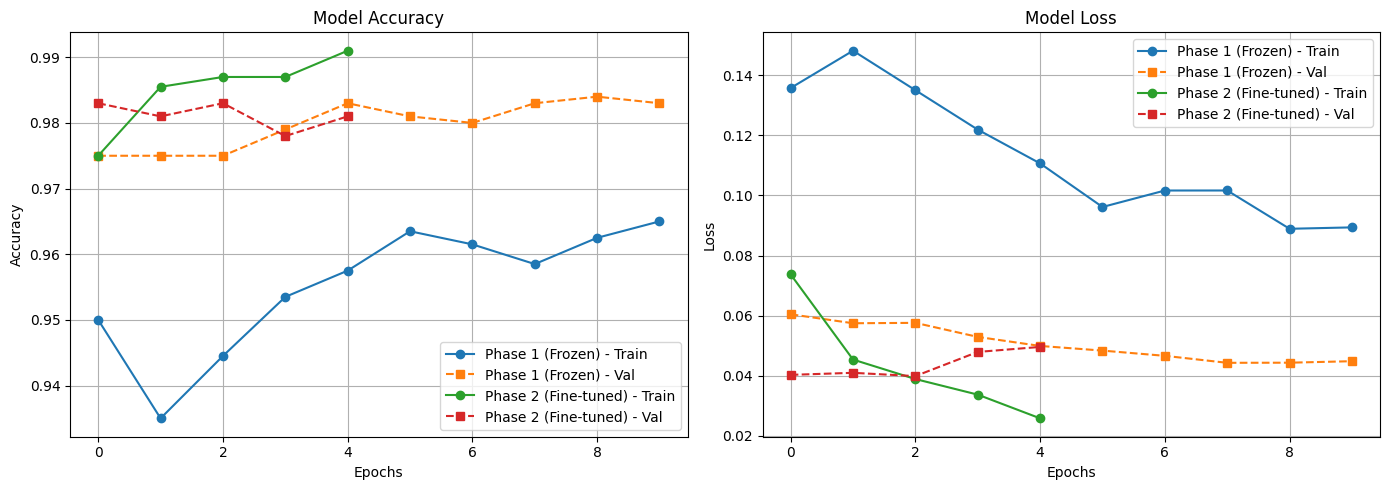

In [13]:
def plot_history(histories, titles):
    plt.figure(figsize=(14, 5))

    # -------- Accuracy --------
    plt.subplot(1, 2, 1)
    for hist, title in zip(histories, titles):
        plt.plot(
            hist.history["accuracy"],
            marker="o",
            label=f"{title} - Train"
        )
        plt.plot(
            hist.history["val_accuracy"],
            marker="s",
            linestyle="--",
            label=f"{title} - Val"
        )

    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    # -------- Loss --------
    plt.subplot(1, 2, 2)
    for hist, title in zip(histories, titles):
        plt.plot(
            hist.history["loss"],
            marker="o",
            label=f"{title} - Train"
        )
        plt.plot(
            hist.history["val_loss"],
            marker="s",
            linestyle="--",
            label=f"{title} - Val"
        )

    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot Phase 1 and Phase 2
plot_history(
    [history_phase1, history_phase2],
    ["Phase 1 (Frozen)", "Phase 2 (Fine-tuned)"]
)



In [16]:
# Evaluate model
results = model.evaluate(validation_generator, verbose=0)
metrics_dict = dict(zip(model.metrics_names, results))

print("Available metrics:", metrics_dict)

# Handle Keras 3+ (compile_metrics)
if "compile_metrics" in metrics_dict:
    final_acc = metrics_dict["compile_metrics"]
else:
    # Older Keras fallback
    acc_key = next(
        key for key in metrics_dict.keys()
        if "accuracy" in key
    )
    final_acc = metrics_dict[acc_key]

print(f"Final Validation Accuracy: {final_acc*100:.2f}%")
print(f"Final Validation Loss: {metrics_dict['loss']:.4f}")


Available metrics: {'loss': 0.039873212575912476, 'compile_metrics': 0.9829999804496765}
Final Validation Accuracy: 98.30%
Final Validation Loss: 0.0399


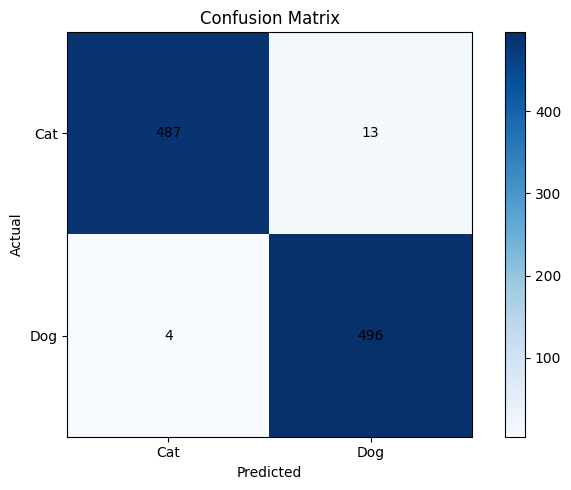

In [21]:
plt.figure(figsize=(7, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Cat", "Dog"]
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)

# Annotate cells
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


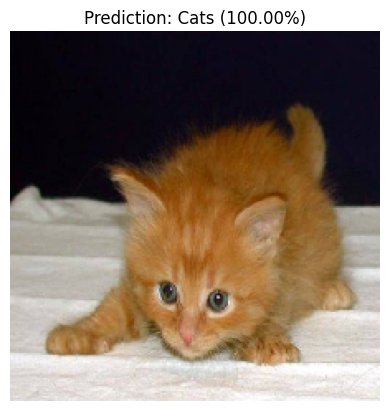

In [22]:
import random  # ensure availability

# Pick a random validation image
img_path = random.choice(validation_generator.filepaths)

# Load and preprocess image
img = tf.keras.preprocessing.image.load_img(
    img_path,
    target_size=IMG_SIZE
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
prediction = model.predict(img_array, verbose=0)[0][0]

# Get class labels safely
class_indices = validation_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

predicted_class = index_to_class[int(prediction > 0.5)]
confidence = prediction if prediction > 0.5 else 1 - prediction

# Display result
plt.imshow(img)
plt.title(f"Prediction: {predicted_class.capitalize()} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()


In [23]:
model.save("vgg16_cats_dogs_transfer_learning.keras")
print("Model saved successfully!")


Model saved successfully!
